In [42]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation,Dropout
from keras.models import Model,load_model
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [43]:
def load_dataset(path):
    data = load_files(path) #load all files from the path
    files = np.array(data['filenames']) #get the file  
    targets = np.array(data['target'])#get the the classification labels as integer index
    target_labels = np.array(data['target_names'])#get the the classification labels 
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset('train')
x_test, y_test,_ = load_dataset('test')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Training set size :  40
Testing set size :  20


In [44]:
y_train = [int(i)-1 for i in y_train]
y_test = [int(i)-1 for i in y_test]

In [45]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.1,random_state = 1)

In [46]:
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(len(y_train)))
print ("x_validate shape: " + str(x_validate.shape))
print ("y_validate shape: " + str(len(y_validate)))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(len(y_test)))

x_train shape: (36,)
y_train shape: 36
x_validate shape: (4,)
y_validate shape: 4
x_test shape: (20,)
y_test shape: 20


We need to convert jpg file to numpy array to feed to the CNN.
Opencv library is used to perform this task.

In [47]:
def convert_image_to_array(files):
    width, height, channels = 100, 100, 3
    images_as_array = np.empty((files.shape[0], width, height, channels), dtype=np.uint8) #define train and test data shape
    for idx,file in enumerate(files):
        img = cv2.imread(file) 
        res = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC) #As images have different size, resizing all images to have same shape of image array
        images_as_array[idx] = res
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_validate))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Training set shape :  (36, 100, 100, 3)
Validation set shape :  (4, 100, 100, 3)
Test set shape :  (20, 100, 100, 3)


In [48]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

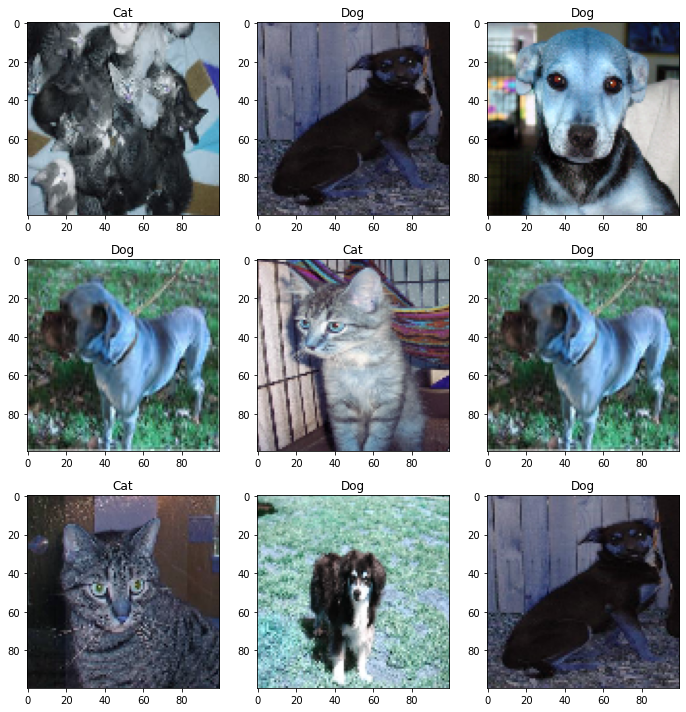

In [49]:
plt.figure(figsize=(10,10))
classes = ['Cat','Dog']
for i in range(1,10):
    index = np.random.randint(x_train.shape[0])
    plt.subplot(3, 3, i)
    plt.imshow(np.squeeze(x_train[index]), cmap='cool')
    plt.title(classes[y_train[index]])
    plt.tight_layout()
plt.show()

Apply data augmentation 

In [50]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

Define the model

In [51]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(5, 5),kernel_initializer='he_normal',activation='relu',input_shape=(100,100,3),name = 'conv1'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,name = 'maxpool1'))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',name = 'conv2'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2,name = 'maxpool2'))
model.add(Flatten(name='fc'))
model.add(Dense(32, activation='relu',name = 'Dense0'))
model.add(Dropout(0.4,name='dropout4'))
model.add(Dense(2, activation='softmax',name = 'Dense3'))

model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [52]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 32), epochs = 100, verbose=1,validation_data=(x_valid,y_validate))

Epoch 1/100
2/2 [==============================] - 1s 573ms/step - loss: 3.4449 - accuracy: 0.4444 - val_loss: 0.9738 - val_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 1s 318ms/step - loss: 2.5945 - accuracy: 0.5278 - val_loss: 0.7502 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 1s 350ms/step - loss: 0.7957 - accuracy: 0.5278 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 1s 358ms/step - loss: 0.7501 - accuracy: 0.4722 - val_loss: 0.7104 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 1s 339ms/step - loss: 0.7406 - accuracy: 0.4444 - val_loss: 0.6760 - val_accuracy: 0.5000
Epoch 6/100
2/2 [==============================] - 1s 358ms/step - loss: 0.7123 - accuracy: 0.5556 - val_loss: 0.6840 - val_accuracy: 0.5000
Epoch 7/100
2/2 [==============================] - 1s 340ms/step - loss: 0.6923 - accuracy: 0.4444 - val_loss: 0.6829 - val_accuracy: 0.5000
Epoch 8/100
2

In [53]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss :',score[0])
print('Test Accuracy :',score[1])

Test Loss : 0.6821832656860352
Test Accuracy : 0.550000011920929


Let's train the model for 200 epochs

In [55]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 32), epochs = 200, verbose=0,validation_data=(x_valid,y_validate))

In [56]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss :',score[0])
print('Test Accuracy :',score[1])

Test Loss : 0.6975162029266357
Test Accuracy : 0.4000000059604645


Let's train the model for 300 epochs

In [57]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 32), epochs = 300, verbose=0,validation_data=(x_valid,y_validate))

In [58]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss :',score[0])
print('Test Accuracy :',score[1])

Test Loss : 1.3547515869140625
Test Accuracy : 0.550000011920929
